In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

from resalloc.fungible import AllocationProblem
from resalloc.fungible import utilities

from latexify import latexify
latexify()

In [2]:
def make_problem(n_jobs, n_resources, device):

    resource_limits = torch.rand(n_resources, device=device) * n_jobs + 1e3
    job_demands = None
    utility_fn = utilities.Log()
    
    throughput_matrix = torch.tensor(
        np.random.uniform(low=1., high=2., size=(n_jobs, n_resources))
    ).float()
    throughput_matrix = throughput_matrix.to(device)

    problem = AllocationProblem(
        throughput_matrix,
        resource_limits=resource_limits,
        job_demands=job_demands,
        utility_function=utility_fn
    )
    return problem

In [3]:
from collections import namedtuple

Stats = namedtuple('Stats', ['mean', 'std', 'min', 'max'])

In [4]:
from tqdm.auto import tqdm
import time

resources = torch.tensor(np.linspace(start=2, stop=100, num=10)).int()
jobs = [int(1e5)]*len(resources)
n_trials = 5

def benchmark(device, jobs, resources, n_trials):
    device_times = []
    for j, r in tqdm(list(zip(jobs, resources))):
        print(f'{r} RESOURCES')

        torch.manual_seed(0)
        np.random.seed(0)

        times = []
        for i in tqdm(range(n_trials)):
            problem = make_problem(j, r, device)
            prices = problem.utility_fn.initial_prices(problem)
            start = time.time()
            #_, stats = problem.solve(eps=eps, max_iter=max_iter, print_every=1, verbose=False)
            problem.evaluate_dual_function(prices)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            del problem
            times.append(end - start)
        times = np.array(times)
        mean = np.mean(times)
        std = np.std(times)
        min_ = np.min(times)
        max_ = np.max(times)
        device_times.append(Stats(mean, std, min_, max_))
    return device_times


In [5]:
gpu_stats = benchmark('cuda', jobs, resources, n_trials)

In [6]:
cpu_stats = benchmark('cpu', jobs, resources, n_trials)

  0%|          | 0/10 [00:00<?, ?it/s]

2 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

12 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

23 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

34 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

45 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

56 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

67 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

78 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

89 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

100 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
jobs_j = list(map(int, [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
resources_j = [4]*len(jobs_j)

In [8]:
gpu_stats_j = benchmark('cuda', jobs_j, resources_j, n_trials)
cpu_stats_j = benchmark('cpu', jobs_j, resources_j, n_trials)

  0%|          | 0/6 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
import cvxpy as cp

def times_errs(stats):
    times = np.array([s.mean for s in stats])
    up_err = [s.max - s.mean for s in stats]
    down_err = [s.mean - s.min for s in stats]
    yerr = np.array([up_err, down_err])
    return times, yerr

cpu_t, cpu_err = times_errs(cpu_stats)
cpu_t_j, cpu_err_j = times_errs(cpu_stats_j)

a = cp.Variable()
b = cp.Variable()

start = 1
targets = np.log(cpu_t)
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(resources[start:])))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

cpu_t_inputs = np.linspace(resources[start], 100, 100)
cpu_t_quad_fit = np.exp((a.value + b.value*(np.log(cpu_t_inputs))))
cpu_t_quad_fit

a = cp.Variable()
b = cp.Variable()

targets = np.log(gpu_t)
start = 1
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(resources[start:].cpu().numpy())))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

gpu_t_inputs = np.linspace(resources[start], resources[-1], 100)
gpu_t_fit = np.exp(a.value + b.value*(np.log(gpu_t_inputs)))
gpu_t_fit


a = cp.Variable()
b = cp.Variable()

targets = np.log(cpu_t_j)
start = 2
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(np.array(jobs_j[start:]))))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

cpu_t_j_inputs = np.linspace(jobs_j[start], jobs_j[-1], 100)
cpu_t_j_fit = np.exp((a.value + b.value*(np.log(cpu_t_j_inputs))))
cpu_t_j_fit

a = cp.Variable()
b = cp.Variable()

start = 3
targets = np.log(gpu_t_j)
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(np.array(jobs_j[start:]))))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

gpu_t_j_inputs = np.linspace(jobs_j[start], jobs_j[-1], 100)
gpu_t_j_fit = np.exp(a.value + b.value*(np.log(gpu_t_j_inputs)))
gpu_t_j_fit


0.0014499234446240462
2.0313552904695404
6.74958287516051e-05
1.748695236968488
1.6170273979732102e-07
1.051487265122501
1.7333945162643855e-07
0.8144489170947226


array([0.00204711, 0.00360011, 0.00500879, 0.00633124, 0.00759307,
       0.00880859, 0.00998691, 0.01113429, 0.0122553 , 0.01335337,
       0.01443122, 0.01549102, 0.01653453, 0.01756324, 0.0185784 ,
       0.01958106, 0.02057216, 0.02155248, 0.02252275, 0.02348359,
       0.02443555, 0.02537913, 0.02631478, 0.02724291, 0.0281639 ,
       0.02907807, 0.02998573, 0.03088718, 0.03178268, 0.03267246,
       0.03355675, 0.03443577, 0.0353097 , 0.03617873, 0.03704303,
       0.03790276, 0.03875808, 0.03960911, 0.04045599, 0.04129886,
       0.04213782, 0.042973  , 0.04380449, 0.0446324 , 0.04545683,
       0.04627787, 0.0470956 , 0.0479101 , 0.04872147, 0.04952977,
       0.05033507, 0.05113745, 0.05193697, 0.0527337 , 0.05352769,
       0.05431901, 0.05510771, 0.05589385, 0.05667748, 0.05745864,
       0.0582374 , 0.05901379, 0.05978785, 0.06055965, 0.0613292 ,
       0.06209657, 0.06286178, 0.06362487, 0.06438588, 0.06514485,
       0.06590181, 0.0666568 , 0.06740984, 0.06816097, 0.06891

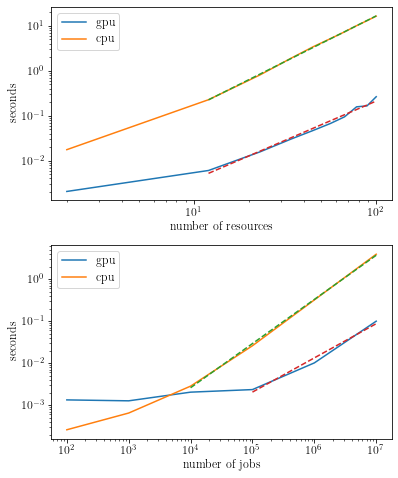

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(5.7, 6.8))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].plot(resources, gpu_t, label='gpu')
axs[0].plot(resources, cpu_t, label='cpu')
axs[0].plot(cpu_t_inputs, cpu_t_quad_fit, linestyle='--')
axs[0].plot(gpu_t_inputs, gpu_t_fit, linestyle='--')
axs[0].set_xlabel('number of resources')
axs[0].set_ylabel('seconds')
axs[0].legend()

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot(jobs_j, gpu_t_j, label='gpu')
axs[1].plot(jobs_j, cpu_t_j, label='cpu')
axs[1].plot(cpu_t_j_inputs, cpu_t_j_fit, linestyle='--')
axs[1].plot(gpu_t_j_inputs, gpu_t_j_fit, linestyle='--')
axs[1].set_xlabel('number of jobs')
axs[1].set_ylabel('seconds')
axs[1].legend()
plt.tight_layout()
plt.savefig('scaling.pdf')

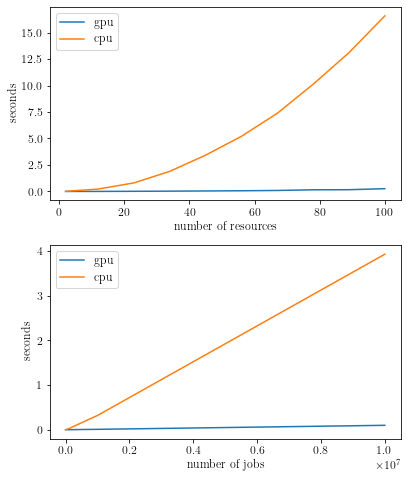

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(5.7, 6.8))

axs[0].plot(resources, gpu_t, label='gpu')
axs[0].plot(resources, cpu_t, label='cpu')
axs[0].set_xlabel('number of resources')
axs[0].set_ylabel('seconds')
axs[0].legend()

axs[1].plot(jobs_j, gpu_t_j, label='gpu')
axs[1].plot(jobs_j, cpu_t_j, label='cpu')
axs[1].set_xlabel('number of jobs')
axs[1].set_ylabel('seconds')
axs[1].legend()
plt.tight_layout()